# Gist  

### 1. Problem
Below I am attempting a differentiable programming solution to what is arguably the oldest and most challenging inverse problem.   
The governing equation of the inverse problem we are interested in is none other than the (inhomogeneous) Hemlholtz Equation:  

$$\begin{equation}
\label{eq:helm}
\nabla^2\Psi(\mathbf{r}) + k^2 \psi(\mathbf{r}) = -i \sigma V(\mathbf{r})\psi(\mathbf{r})
\end{equation}
$$
where $\Psi$ is the wavefield, $V$ is the scattering potential, $k^2$ is the wavevector, and $\sigma$ is an interaction strength (or coupling constant).    
The equation above is generally applicable to all forms of radiation (lasers, x-rays...) as well as matter waves (high-energy electron beams, neutrons, etc...).  
In its most general formulation, $\Psi$ is a vector-valued complex field (i.e. to encode polarization states) or in the case of matter waves $\Psi$ is a 4-d spinor. Here, we will ignore polarization states, etc... s.t. we are dealing with scalar fields:  
$$\Psi: \mathbb{R}^3 \rightarrow \mathbb{C}, \quad V: \mathbb{R}^3 \rightarrow \mathbb{R}$$ 

The inverse problem we want to solve is given some data $D = ||\Psi_\textrm{out}||^2$, we would like to recover $V$ (and $\Psi_\textrm{in}$, most researchers only care about $V$ 🤪).  
Multiple variants of this problem arise in many fields and contexts. For instance, in imaging and sensing this inverse problem is known as object reconstruction (i.e. $V$) and in (diffraction) physics/optics it is known as the phase problem ($\arg(\Psi_\textrm{out})$ is not a measurable quantity). 

### 2. Digression #####
-----
```There is tons of approaches to solve this inverse problem (e.g. holography, tomography,) and some like Gabor and Zernike were awarded Nobel Prizes for their work on this problem ... afterall it is the **original inverse problem!**  
So, why bother finding yet another solution to this problem? well... (spoiler alert!!!🚒) none of the above solutions *actually work* in a general sense!  
And by "work in a general sense" I mean: 
1. Algo: here's the associated algorithm 
2. Data: feed it your data 
3. Solution: out comes out get a pretty good solution. 🎊

In fact, researchers, engineers, and companies have spent decades building instruments (CT scanners, microscopes, lightsources, etc...) to make the reconstruction of V easier (or in some cases, like a microscope, trivial!).   

```
-----

### 3. Paraxial Approximation and the Multi-Slice Algorithm
In what follows we use the paraxial approximation to the inhomogeneous Helmholtz equation:

$$\begin{equation}
\frac{\partial \Psi(\mathbf{r}_\perp)}{\partial z} = \frac{i \lambda}{4 \pi} \nabla_{\perp}^2 \psi(\mathbf{r}_\perp) + i \sigma V(\mathbf{r})\psi(\mathbf{r}_\perp)
\end{equation}
$$


In [2]:
using CuArrays, CUDAdrv, CUDAnative
using Plots, LinearAlgebra, Flux, NPZ
using Flux: Optimise
using Zygote
using FFTW

# FFTW.set_num_threads(40)

# MSA imports
include("MSA.jl")
using .MSA

# CUDAnative.device!(3)
# CuArrays.allowscalar(true)

┌ Warning: You are using CUDNN 7.6.5 for CUDA 10.2.0 with CUDA toolkit 10.1.243; these might be incompatible.
└ @ CuArrays /home/nl7/.julia/packages/CuArrays/HE8G6/src/CuArrays.jl:127


In [178]:
soft_aperture = Dict("type" => "soft", 
                     "factor" => 100.0)
hard_aperture = Dict("type" => "hard")
probe = Dict("phase_error" => "spherical", 
             "C1" => 0., 
             "C3" => 0., 
             "C5" => 0., 
             "Scherzer" => false)
simParams = MSA.SimulationState(0.05, 128, 5.6, 0.02, soft_aperture, probe)
probe_positions=[(0,0)]
sigma = 1e-2
slice_thickness = 1
num_slices = 4

# load a potential
v_file = npzread("../potential_7559.npy")
if simParams.sampling == 128
    crop_top = map(Int, [size(v_file)[1] * (1/4), size(v_file)[2] * (3/4)])
else
    crop_top = map(Int, [size(v_file)[1] * (1/8), size(v_file)[2] * (3/8)])
end
slice = range(crop_top[1], stop=crop_top[2]-1)
v_file = v_file[slice, slice]
size(v_file)

(128, 128)

### Utils


In [162]:
mutable struct ForwardModel
    psi::AbstractArray
    potential::AbstractArray
    simParams::MSA.SimulationState
    name::String
end

function forward(model::ForwardModel)
    psi_buff = Zygote.Buffer(model.potential)
    psi_out = MSA.multislice(model.psi, psi_buff, model.potential, model.simParams.λ, slice_thickness, sigma)
    psi2_out = abs2.(fft(psi_out[:,:,end], [1,2]))
    return psi2_out
end

function loss(model::ForwardModel, psi2_trg)
    res = norm(forward(model) .^ 0.5 .- psi2_trg .^ 0.5, 2)
    return res
end

function sgd_update!(model::ForwardModel, grads, η = 0.01; verbose=false)
    if verbose 
        @info("Gradients:
            ∂V=$(round.(grads.potential; digits=2))
            ∂ѱ=$(round.(grads.psi; digits=2))")
        @info("before sgd update:
        V'=$(round.(model.potential; digits=2))
        ѱ'=$(round.(model.psi; digits=2))")
    end
    model.psi .-= η .* grads.psi
    model.potential .-= η .* grads.potential
    if verbose
        @info("after sgd update:
        V'=$(round.(model.potential; digits=2))
        ѱ'=$(round.(model.psi; digits=2))")
    end
end

function comp_plot(psi_out, psi_in, V)
    l = @layout [a b c]
    p1 = heatmap(abs2.(psi_in[:,:,1]) .^ 0.25, aspect_ratio=1, framestyle = :none)
    p2 = heatmap(psi_out[:,:,1] .^ 0.1, aspect_ratio=1, framestyle = :none)
    p3 = heatmap(abs2.(V[:,:,1]), aspect_ratio=1, framestyle = :none, color = :viridis)
    heatmap(p1, p2, p3, layout=l, title=["Psi_in" "Data" "V"], size=(1200,400))
    
end

function diff_plot(psi_out_pred, psi_out_true;clims=:auto)
    heatmap(abs.(psi_out_pred[:,:,1] .- psi_out_true[:,:,1])./ psi_out_true[:,:,1] .* 100, 
        aspect_ratio=1, framestyle= :none, title="% Difference", clims= clims)
end

diff_plot (generic function with 1 method)

### Generate Solution by simulating $F$

┌ Info: Initiate Wavefunction and Scattering Potential...
└ @ Main In[179]:2


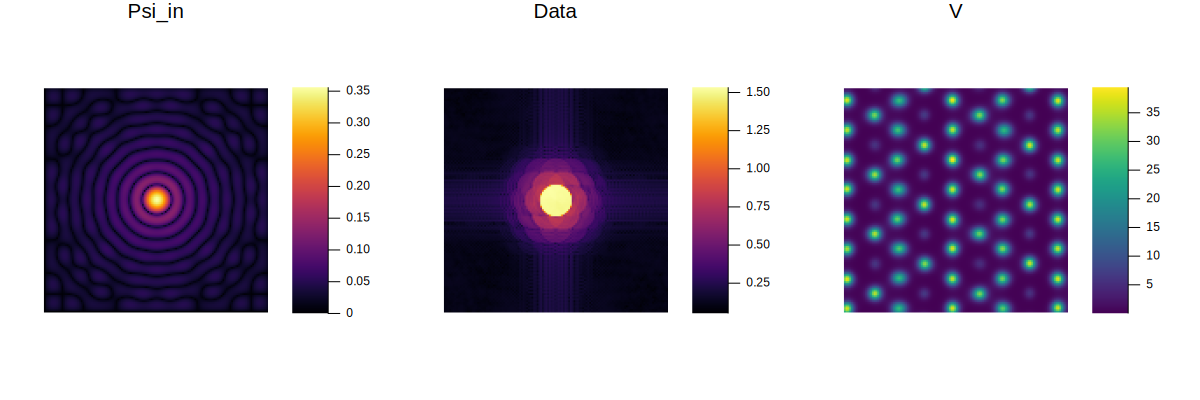

In [179]:
k_size = (simParams.sampling,simParams.sampling)
@info("Initiate Wavefunction and Scattering Potential...") 
psi, _ = MSA.build_probe(simParams)
psi_trg = psi
cpy_trg = copy(psi_trg)
V_trg = randn(ComplexF32, (k_size..., num_slices)) 
for idx in 1:size(V_trg, 3)
    V_trg[:,:,idx] = im * v_file
end
MSA.multislice!(psi_trg, V_trg, simParams.λ, slice_thickness, sigma)
psi2_trg = abs2.(psi_trg)
comp_plot(psi2_trg, cpy_trg, V_trg)

### Initiate Differentiable Forward Model, $\partial F$

┌ Info: Initiate Forward Model...
└ @ Main In[187]:1


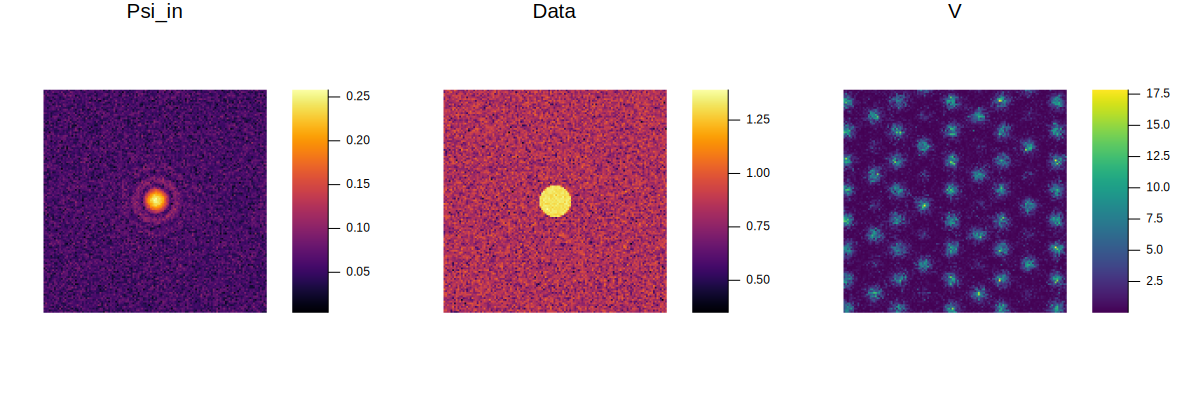

In [187]:
@info("Initiate Forward Model...")
scale = Float32(5e-1)
psi_in = randn(ComplexF32, size(psi_trg))
psi_in ./= sqrt.(sum(abs2.(psi_in)))
psi, _ = MSA.build_probe(simParams)
psi_mixing = 0.5
V_mixing = 0.5
psi_in = psi_mixing * psi + (1 - psi_mixing) * psi_in 
V_in = V_mixing * V_trg + (1 - V_mixing) * im * randn(Float32, size(V_trg))
model = ForwardModel(psi_in, V_in, simParams, "∂F")
comp_plot(forward(model), model.psi, V_in)

In [188]:
# model gradients
@info("Differentiating Forward Model...")
grads = gradient(model) do m
    return loss(m, psi2_trg)
end
nothing

┌ Info: Differentiating Forward Model...
└ @ Main In[188]:2


### Difference between initial $\partial F$ and solution

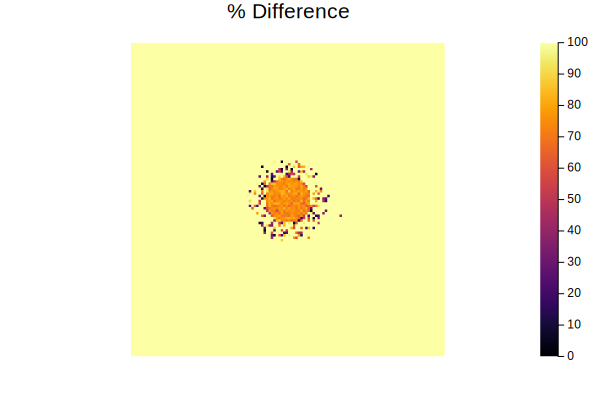

In [189]:
diff_plot(forward(model), psi2_trg, clims=(0,100))
# diff_plot(abs2.(model.psi), abs2.(psi_in))

### Optimize

In [190]:
opt = ADAM(1e-5)
@info("Running train loop")
idx = 0
loss_val = loss(model, psi2_trg)
max_iter = 5e3
num_logs = 200
verbose = false
model_hist = Array{Tuple}(undef,num_logs)
loss_hist = Array{Float32}(undef, num_logs)
iter_hist = Array{Float32}(undef, num_logs)
hist_idx = 1
@time while idx < max_iter && loss_val > 1e-4
    if mod(idx, max_iter ÷ num_logs) == 0
        Zygote.@nograd loss_val = loss(model, psi2_trg)
        println("Iteration=$(idx), Loss=$loss_val")
        model_hist[hist_idx] = (model.psi[:,:,1], model.potential[:,:,:])
        loss_hist[hist_idx] = loss_val
        iter_hist[hist_idx] = idx
        global hist_idx += 1
    end
    grads= Zygote.gradient(model) do m
        return loss(m, psi2_trg)
    end
    grads = grads[1][]
#     sgd_update!(model, grads, 1e-3; verbose=false)
    Optimise.update!(opt, model.psi, grads.psi)
    Optimise.update!(opt, model.potential, grads.potential)
    global idx += 1
end

Iteration=0, Loss=89.90510847480478
Iteration=25, Loss=87.96617172818219
Iteration=50, Loss=86.14210145159906
Iteration=75, Loss=84.42205229464115
Iteration=100, Loss=82.79879094682668
Iteration=125, Loss=81.26425229898402
Iteration=150, Loss=79.80916608432938
Iteration=175, Loss=78.42399939799162
Iteration=200, Loss=77.09948479629973
Iteration=225, Loss=75.82420764279952
Iteration=250, Loss=74.59132109132061
Iteration=275, Loss=73.39305611522863
Iteration=300, Loss=72.21808868569502
Iteration=325, Loss=71.0549387740848
Iteration=350, Loss=69.89004493649709
Iteration=375, Loss=68.70876973179001
Iteration=400, Loss=67.50387434890321
Iteration=425, Loss=66.27227539104564
Iteration=450, Loss=65.01170479047677
Iteration=475, Loss=63.72022906935809
Iteration=500, Loss=62.40248454732199
Iteration=525, Loss=61.06492803350291
Iteration=550, Loss=59.7177859889815
Iteration=575, Loss=58.362958564753065
Iteration=600, Loss=57.01208898880836
Iteration=625, Loss=55.67465790706926
Iteration=650, Los

┌ Info: Running train loop
└ @ Main In[190]:2


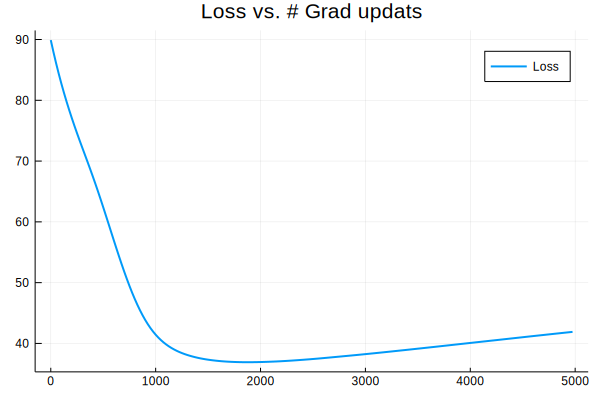

In [191]:
plot(iter_hist, loss_hist, lw=2, title="Loss vs. # Grad updats", label="Loss")

### Difference between optimized $\partial F$ and solution

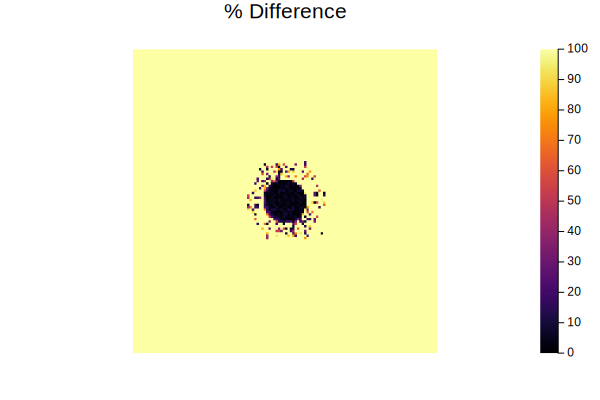

In [192]:
diff_plot(forward(model), psi2_trg; clims=(0,100))

### Optimization History of $\bar\Psi_{\textrm{in}}$

In [2]:
anim = @animate for ((psi,potential), iter) in zip(model_hist, 0:num_logs:idx)
    psi = abs2.(psi[:,:,1]) .^ 0.5
    pot = sum(abs2.(potential), dims=3)[:,:,1]
    l = @layout [a b]
    p1 = heatmap(psi, aspect_ratio=1, framestyle = :none, color= :vibrant_grad)
    p2 = heatmap(pot .^ 0.5, aspect_ratio=1, framestyle = :none, color= :vibrant_grad)
    heatmap(p1, p2, layout=l, title=["Psi_in\n Iterations=$iter" "V"], size=(800,400))
end

LoadError: UndefVarError: @animate not defined

In [1]:
gif(anim, "diffProg_psi_in.gif", fps=5)

UndefVarError: UndefVarError: gif not defined

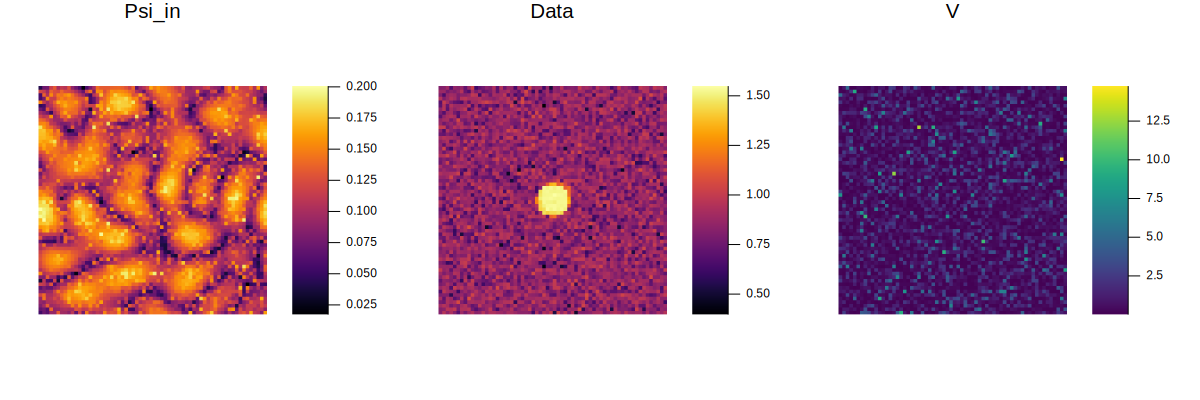

In [172]:
comp_plot(forward(model), model.psi, model.potential)

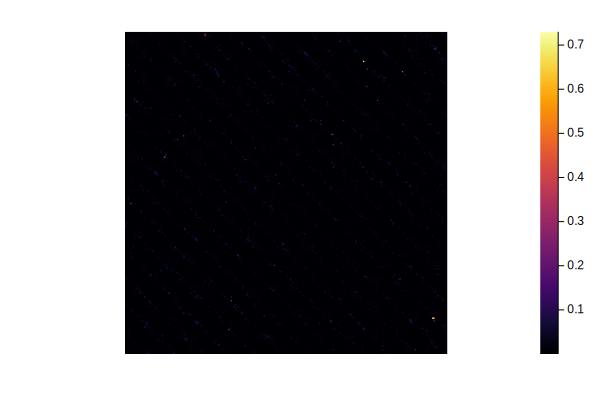

In [25]:
prod_pred = model.psi .* MSA.build_transmPropagator(model.potential[:,:,1],sigma)
heatmap(abs2.(prod_pred)[:,:,1], aspect_ratio=1, framestyle= :none)

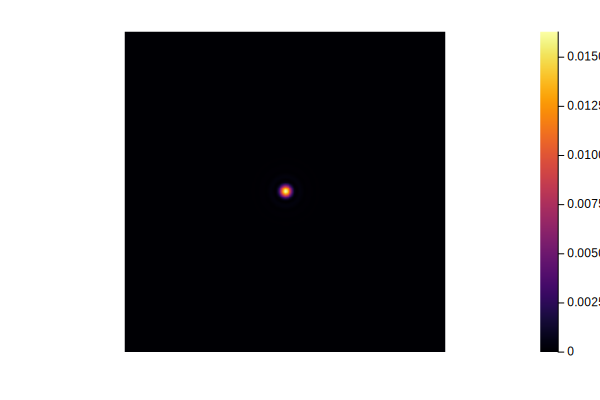

In [26]:
prod_true = psi .* MSA.build_transmPropagator(V_trg[:,:,1],sigma)
heatmap(abs2.(prod_true)[:,:,1], aspect_ratio=1, framestyle= :none)